# CNN Regression Model

In [1]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load,dump
import math
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import backend as K
from scipy import signal

## Sample

<AxesSubplot:title={'center':'Velocity'}>

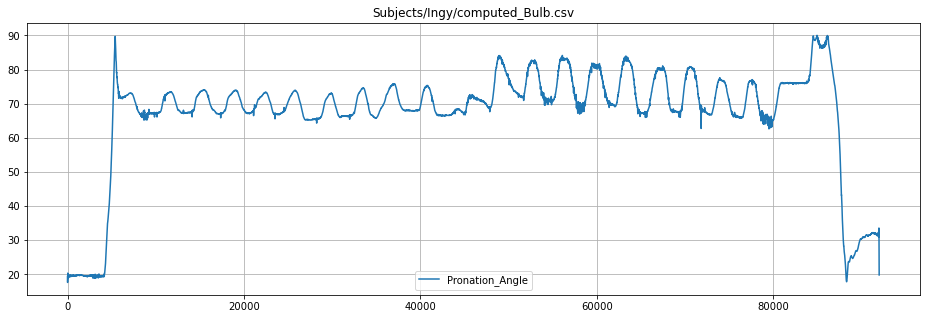

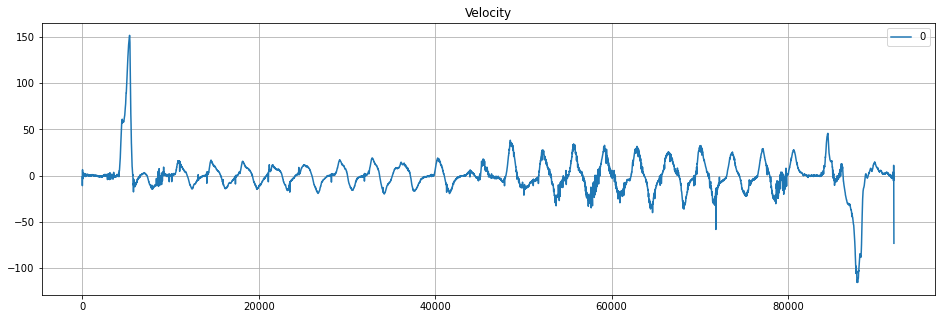

In [57]:
file = 'Subjects/Ingy/computed_Bulb.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Pronation_Angle'] # 'Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle'
df = pd.read_csv(file,index_col=0)#[62500:69000]#[4500:85000]#[72500:82500]
df[angle_lables].plot(figsize=(16,5),title=file,grid=True)

# arr = np.diff([0]+list(df['Pronation_Angle']))
arr = np.diff(list(df['Pronation_Angle'])+[list(df['Pronation_Angle'].values)[-1]])
arr = arr/(1/2000)
b,a = signal.butter(1, 1,fs=2000)
arr = signal.lfilter(b, a,arr)
pd.DataFrame(arr).plot(figsize=(16,5),title='Velocity',grid=True)

In [2]:
def preprocessor_arr(emg_arr):
    fs = 2000
    n = 4
    Fa = 80
    Fb = 800
    cf = np.array([Fa,Fb])
    emg_arr_1 = filter_array(emg_arr,cf=cf,order=n,fs=fs,btype='bandpass')
    emg_arr_2 = abs(emg_arr_1)
#     emg_arr_2 = filter_array(emg_arr_2,cf=6,order=4,fs=fs,btype='lowpass')
    return emg_arr_2
def preprocessor_df(df):
    emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8', 'EMG9', 'EMG10', 'EMG11', 'EMG12']
    fdf = df.copy()
    for lbs in emg_labels:
        fdf[lbs] = preprocessor_arr(df[lbs].values)
    return fdf
def filter_array(arr,cf,order=1,fs=2000,btype='lowpass'):
    if len(arr.reshape((-1)).shape) < 2:
        arr = arr.reshape((-1))
    b,a = signal.butter(order, cf,fs=fs,btype=btype)
    arr = signal.lfilter(b, a,arr)
    return arr

## Prep Data

In [3]:
window = 250

In [4]:
files = []
subjects = ['Fazil','Nikhil','Varun','Abhishek','Jai', 'Deepti', 'Nirmayee'] #'Fazil/day_04_14_21' ,'Ingy'
# subjects = ['Ingy'] #'Fazil/day_04_14_21' ,'Varun'
for subj in subjects:
    path = 'Subjects/'+subj
    trial_names = ['Bulb'] # 'Bulb','Hammer' ,'Cup','Screw'
#     trial_names = ['Bulb','Screw','Hammer' ,'Cup',] #
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/computed_Bulb.csv',
 'Subjects/Fazil/computed_Bulb01.csv',
 'Subjects/Fazil/computed_Bulb02.csv',
 'Subjects/Nikhil/computed_Bulb.csv',
 'Subjects/Nikhil/computed_Bulb01.csv',
 'Subjects/Nikhil/computed_Bulb02.csv',
 'Subjects/Varun/computed_Bulb.csv',
 'Subjects/Varun/computed_Bulb01.csv',
 'Subjects/Varun/computed_Bulb02.csv',
 'Subjects/Abhishek/computed_Bulb.csv',
 'Subjects/Abhishek/computed_Bulb01.csv',
 'Subjects/Abhishek/computed_Bulb02.csv',
 'Subjects/Jai/computed_Bulb.csv',
 'Subjects/Jai/computed_Bulb01.csv',
 'Subjects/Jai/computed_Bulb02.csv',
 'Subjects/Deepti/computed_Bulb.csv',
 'Subjects/Deepti/computed_Bulb01.csv',
 'Subjects/Deepti/computed_Bulb02.csv',
 'Subjects/Nirmayee/computed_Bulb.csv',
 'Subjects/Nirmayee/computed_Bulb01.csv',
 'Subjects/Nirmayee/computed_Bulb02.csv']

In [5]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0)[4500:85000])

In [6]:
files_df = filter_df(files_df)

### Remove Test Reps Data

In [6]:
test_rep_files = ['Subjects/Ingy/computed_Bulb02.csv', 
                  'Subjects/Ingy/computed_Screw02.csv']
tr_range = [29000,37000]

In [8]:
files_df = []
for file in files:
    if file in test_rep_files:
        df = pd.read_csv(file,index_col=0)[4500:85000]
        df = df.drop(df.index[tr_range[0]:tr_range[1]])
    else:
        df = pd.read_csv(file,index_col=0)[4500:85000]
    files_df.append(df)
files_df = filter_df(files_df)

### Only Removed Reps

In [41]:
files_df = []
files = test_rep_files
for file in files:
    df = pd.read_csv(file,index_col=0)
    files_df.append(df[tr_range[0]:tr_range[1]])
files_df = filter_df(files_df)

F:\The Stuffs\Awear\Final_Project\wrist_data_collection_AWEAR\Data_preparation_Library.py:467: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files_df[i][emg_labels] = np.array(emg_df)
C:\Users\moham\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


## Rearrange

In [7]:
from collections import deque
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
rearr_labels = []
labels = deque(emg_labels)
labels.rotate(1)
rearr_labels.append(list(labels))
labels.rotate(-2)
rearr_labels.append(list(labels))
rearr_labels

[['EMG8', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7'],
 ['EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG1']]

In [6]:
from collections import deque
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
rearr_labels = [emg_labels]
for i in range(8):
    labels = deque(rearr_labels[-1])
    labels.rotate(1)
    rearr_labels.append(list(labels))
rearr_labels = rearr_labels[1:-1]
rearr_labels

[['EMG8', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7'],
 ['EMG7', 'EMG8', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6'],
 ['EMG6', 'EMG7', 'EMG8', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5'],
 ['EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG1', 'EMG2', 'EMG3', 'EMG4'],
 ['EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG1', 'EMG2', 'EMG3'],
 ['EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG1', 'EMG2'],
 ['EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG1']]

In [7]:
files_df_rearrange = []
for df in tqdm(files_df):
    for lb in rearr_labels:
        df[emg_labels] = df[lb]
        files_df_rearrange.append(df) 
    
files_df = files_df+files_df_rearrange
len(files_df)

168

## EMG Preprocessor

In [7]:
files_df_new = []
for df in tqdm(files_df):
    files_df_new.append(preprocessor_df(df))
files_df = files_df_new

In [18]:
del files_df_new

## Generate Training Data

In [12]:
X, y = multiple_prep_data_velocity(files_df,window,interval=5,Normalize=False,rms=False,angle_label ='Pronation_Angle')
X.shape

(337050, 250, 8)

In [ ]:
del files_df

## Time Window Normalize

In [18]:
X_mean = np.zeros(X[0].shape)
for x in X:
    X_mean = X_mean + x
X_mean = X_mean/X.shape[0]
X_std = np.sqrt(variance(X))
np.save('mean_std_prep',np.array([X_mean,X_std]))

In [20]:
X_mean = np.load('mean_std_prep.npy')[0]
X_std = np.load('mean_std_prep.npy')[1]

In [21]:
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

## Min Max Normalize

In [20]:
np.save('max_min_prep',np.array([X.max(),X.min()]))

In [10]:
X_max = np.load('max_min_prep.npy')[0]
X_min = np.load('max_min_prep.npy')[1]

In [11]:
X_new = []
for x in tqdm(X):
    X_new.append((x-X_min)/(X_max - X_min))
X = np.array(X_new)

## Test Train Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(269640, 250, 8)
(67410, 250, 8)
(269640, 1)
(67410, 1)


In [14]:
np.save('prepared_data/X_train',X_train)
np.save('prepared_data/X_test',X_test)
np.save('prepared_data/y_train',y_train)
np.save('prepared_data/y_test',y_test)

In [35]:
np.save('prepared_data/X',X)
np.save('prepared_data/y',y)

In [2]:
X_train = np.load('prepared_data/X_train.npy')
X_test = np.load('prepared_data/X_test.npy')
y_train = np.load('prepared_data/y_train.npy')
y_test = np.load('prepared_data/y_test.npy')
X = np.load('prepared_data/X.npy')
y = np.load('prepared_data/y.npy')

In [36]:
for data in [X_train, X_test, X, y_train, y_test, y]:
    print(data.shape)

(269640, 250, 8)
(67410, 250, 8)
(48150, 250, 8)
(269640, 1)
(67410, 1)
(48150, 1)


# Neural Network Regression

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
n_outputs = 1

In [38]:
checkpoint_filepath = 'best_model_reg.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='Pearson_r',
    mode='max',
    save_best_only=True)

def pearson_r_lossmax(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return -K.mean(r)

In [22]:
n_outputs = 1
filter_size = 27
in_shape = (X_train.shape[1],X_train.shape[2])

model = Sequential()

model.add(Conv1D(filters=256, kernel_size=filter_size, activation='relu', input_shape=in_shape))
model.add(Conv1D(filters=256, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=256, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=256, kernel_size=filter_size, activation='relu'))

model.add(Conv1D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=filter_size, activation='relu'))

model.add(Dropout(0.5))

# model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))
# model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))
# model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))
# model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))

# model.add(Dropout(0.5))

# model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))
# model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))
# model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))
# model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))

# model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
# model.add(Dense(8,activation='relu'))

model.add(Dense(n_outputs,activation='linear'))

# model.compile(loss='mean_squared_error', optimizer='adam')
# model.compile(loss='mean_squared_error', optimizer='adam',metrics=[pearson_r])

model.compile(loss=pearson_r_lossmax, optimizer='adam',metrics=[])



model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 224, 256)          55552     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 256)          1769728   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 172, 256)          1769728   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 146, 256)          1769728   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 120, 64)           442432    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 94, 64)            110656    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 68, 64)           

In [41]:
n_outputs = 1
in_shape = (X_train.shape[1],X_train.shape[2])

model = Sequential()

# model.add(Embedding(input_dim = max_words, output_dim = 1, input_length = max_phrase_len))

model.add(LSTM(256, input_shape = in_shape, return_sequences=True))
model.add(LSTM(256, return_sequences=True))
# model.add(LSTM(128, return_sequences=True))

model.add(Dropout(0.5))

model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))

# model.add(LSTM(64,activation='relu'))
# model.add(LSTM(64,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))

model.add(Dense(n_outputs,activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam',metrics=[pearson_r])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 250, 256)          271360    
_________________________________________________________________
lstm_16 (LSTM)               (None, 250, 256)          525312    
_________________________________________________________________
dropout_7 (Dropout)          (None, 250, 256)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 250, 64)           82176     
_________________________________________________________________
lstm_18 (LSTM)               (None, 250, 64)           33024     
_________________________________________________________________
lstm_19 (LSTM)               (None, 250, 64)           33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 250, 64)          

In [42]:
cnn_history=model.fit(X_train,y_train,epochs = 25,batch_size = 512,validation_data = (X_test,y_test),callbacks=[test_loss(X,y),model_checkpoint_callback])

Epoch 1/25
527/527 [==============================] - 272s 496ms/step - loss: 192.2785 - pearson_r: 0.4865 - val_loss: 123.0929 - val_pearson_r: 0.7346
Pearson_r_Test=  0.10654
Epoch 2/25
527/527 [==============================] - 258s 489ms/step - loss: 76.5784 - pearson_r: 0.8391 - val_loss: 37.6223 - val_pearson_r: 0.9255
Pearson_r_Test=  0.09303
Epoch 3/25
527/527 [==============================] - 256s 486ms/step - loss: 21.3930 - pearson_r: 0.9589 - val_loss: 12.0459 - val_pearson_r: 0.9771
Pearson_r_Test=  0.07156
Epoch 4/25
275/527 [==============>...............] - ETA: 1:50 - loss: 10.8230 - pearson_r: 0.9798

KeyboardInterrupt: 

In [ ]:
best_model = load_model('best_model_reg.hdf5')
best_model.save('models/prosup_velocity_model_prep_{}.hdf5'.format(250))

In [24]:
cnn_history_df = pd.DataFrame(cnn_history.history) 
hist_csv_file = 'regression_history.csv'
with open(hist_csv_file, mode='w') as f:
    cnn_history_df.to_csv(f)

In [25]:
cnn_history_df = pd.read_csv('regression_history.csv')

<AxesSubplot:>

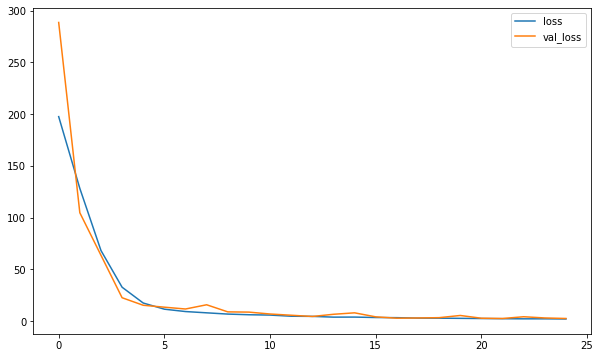

In [26]:
cnn_history_df[['loss', 'val_loss']].plot(figsize=(10,6))

<AxesSubplot:>

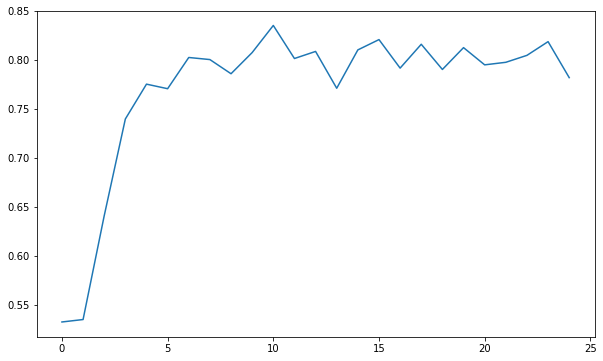

In [27]:
cnn_history_df['Pearson_r'].plot(figsize=(10,6))

## Model Testing

In [3]:
window = 250
best_model = load_model('models/prosup_velocity_model_{}_p86.hdf5'.format(window))
# best_model = load_model('best_model_reg.hdf5')

In [32]:
file = 'Subjects/Fazil/computed_Screw02.csv'
df = pd.read_csv(file,index_col=0)[29000:37000]#[72500:82500]#[4500:85000]#
df = filter_df([df])[0]

In [33]:
X, y = prep_data_velocity(df,window,interval=10,Normalize=True,rms=False,angle_label ='Pronation_Angle')

In [ ]:
X1, y1 = prep_data_velocity(df,window,interval=10,Normalize=True,rms=False,angle_label ='Pronation_Angle')

In [19]:
X = np.vstack((X,X1))
y = np.vstack((y,y1))
print(X.shape,y.shape)

(1550, 250, 8) (1550, 1)


In [87]:
X_mean = np.load('mean_std_master.npy')[0]
X_std = np.load('mean_std_master.npy')[1]
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

25/25 [==============================] - 0s 7ms/step - loss: 0.0064


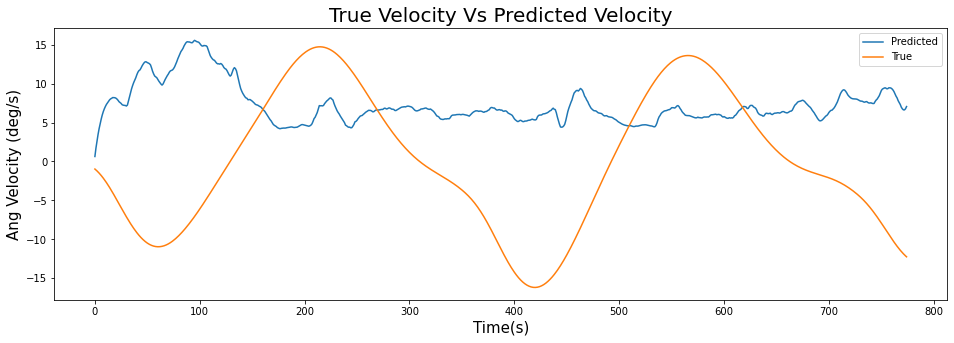

In [56]:
test_model = model
pred = test_model.predict(X)
test_model.evaluate(X,y)

plt.figure(figsize=(16,5))
pred = filter_array(pred,order=1,cf=50,fs=2000)
# y = filter_array(y,order=1,cf=100,fs=2000)
plt.plot(pred)
plt.plot(y)
plt.title('True Velocity Vs Predicted Velocity',size=20)
plt.ylabel('Ang Velocity (deg/s)',size=15)
plt.xlabel('Time(s)', size=15)
plt.legend(['Predicted', 'True'], loc='best')
plt.show()

In [60]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
print('MSE Loss -',mean_squared_error(y,pred))
print('RMSE -',mean_squared_error(y,pred,squared=False))
print('Pearson Correlation Coefficient -',pearsonr(y.flatten(),pred.flatten()))

MSE Loss - 152.06050731563397
RMSE - 12.331281657460995
Pearson Correlation Coefficient - (-0.3867194906965817, 4.7429795576640977e-29)


In [63]:
# pearsonr 0.8

In [20]:
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(xm * ym)
    r_den = K.sum(K.sum(K.square(xm)) * K.sum(K.square(ym)))
    r = r_num / r_den
    return 1 - r**2
    
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

In [21]:
class test_loss(tf.keras.callbacks.Callback):

    def __init__(self, X,y):
        super(test_loss, self).__init__()
        self.X_t = X
        self.y_t = y
        
    def on_epoch_end(self, epoch, logs={}):
        logs['Pearson_r'] = float('-inf')
        pred = self.model.predict(self.X_t)
        score = pearsonr(pred.flatten(),self.y_t.flatten())[0]
        logs['Pearson_r'] = np.round(score, 5)
        print('Pearson_r_Test= ',np.round(score, 5)) 

In [18]:
system_sleep()

In [ ]:
system_shutdown()